<b> <font size = 5> Feature Engineering </b> </font>

In [258]:
#Import basic python packages for data analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import pylab as plot
import matplotlib
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time

### Import Sklearn packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor



### Import Scipy stats packages
from scipy.stats import pearsonr
from scipy.stats import boxcox


# Import statsmodel packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


#Sequential Feature Selector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<b> <font size = 5> Load the Dataframes </b> </font>

In [259]:
## Reading input data
BC_unclustered = pd.read_csv("Data/BC_input.csv")
NO2_unclustered = pd.read_csv("Data/NO2_input.csv")

<b> <font size =3> Load Input Data Frame with Clustered Points</b> </font>

In [260]:
BC= pd.read_csv("Data/BC_input_clustered.csv")
NO2 = pd.read_csv("Data/NO2_input_clustered.csv")

In [261]:
#Drop the first column and rename 'BC Value' and 'NO2 Value'
BC.drop(columns = ['Unnamed: 0'], inplace=True)
NO2.drop(columns = ['Unnamed: 0'], inplace=True)

BC.rename(columns = {'BC Value': 'BC_Value'}, inplace = True)
NO2.rename(columns = {'NO2 Value': 'NO2_Value'}, inplace = True)

In [262]:
# Create a feature list by dropping BC_value and NO2_value
BC_features = BC.drop(columns = ['BC_Value'])
NO2_features = NO2.drop(columns = ['NO2_Value'])


<b> <font size = 5> Identify the features that are highly positively correlated or negatively correlated and fit an OLS on the remaining features </b> </font>

In [263]:
# Next, identify all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation
threshold_1 = 0.90
threshold_2 = -0.90

def features_high_corr(df_features_corr):
    columns = np.full((df_features_corr.shape[0],), True, dtype=bool)
    for i in range(df_features_corr.shape[0]):
        for j in range(i+1, df_features_corr.shape[0]):
            if (df_features_corr.iloc[i,j] >= threshold_1) | (df_features_corr.iloc[i,j] <= threshold_2) :
                if columns[j]:
                    columns[j] = False
    selected_columns = df_features_corr.columns[columns]
    return selected_columns
#df_boston = df_boston[selected_columns]

<b> <font size = 4> BC Dataset </b> </font>

In [264]:
BC_features_corr = BC_features.corr()
BC_features_OLS = features_high_corr(BC_features_corr)
print("Features in BC dataset that are not highly correlated: ")
print(BC_features_OLS)

Features in BC dataset that are not highly correlated: 
Index(['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-AutoRepair-15714511_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections'],
      dtype='object')


In [352]:
#Create a dataframe with BC value and selected columns from Lasso
OLS_BC_df = BC[['BC_Value']].join(BC[['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-AutoRepair-15714511_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections']])

In [353]:
## Plot Correlation matrix
OLS_BC_df_corr = OLS_BC_df.corr()
BC_features_corr_mat = OLS_BC_df_corr.as_matrix()


module://ipykernel.pylab.backend_inline


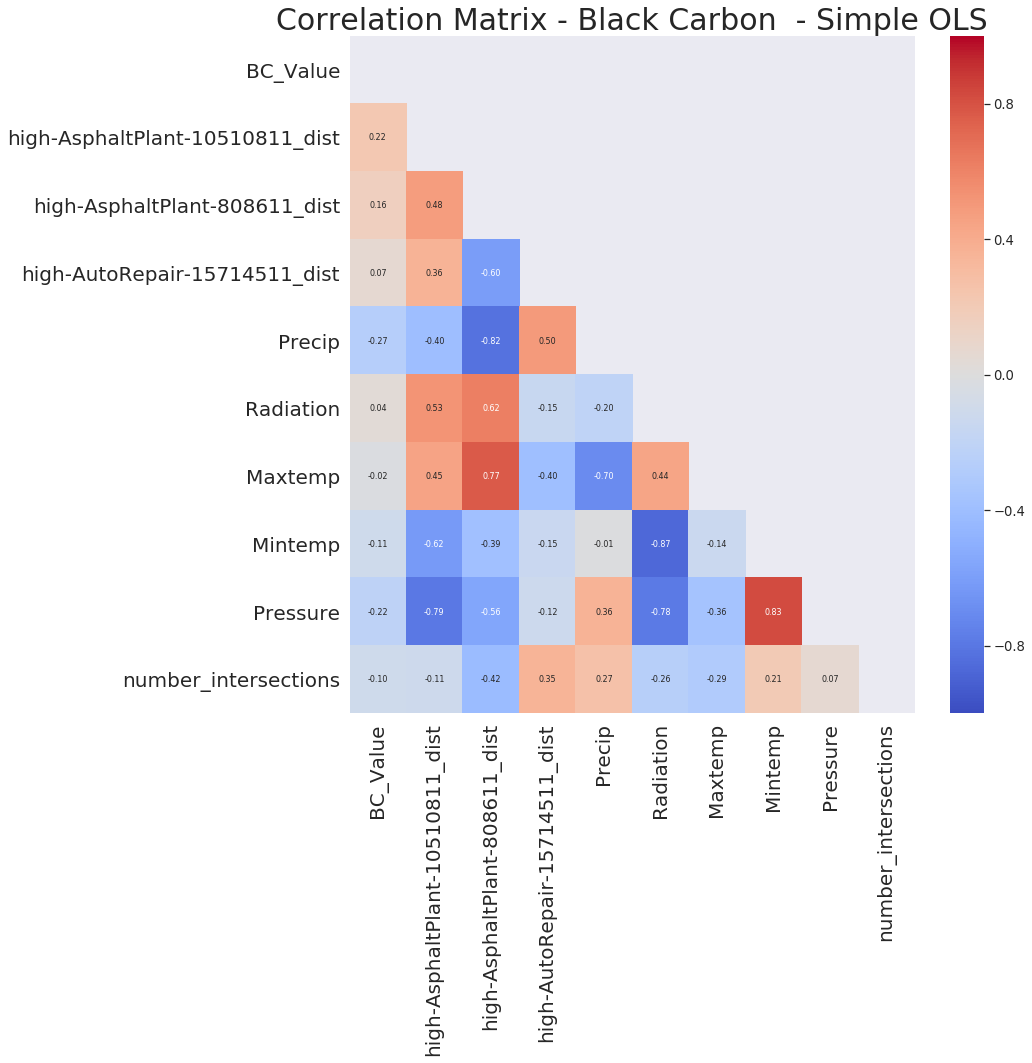

In [358]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
BC_features_corr_mat[np.triu_indices_from(BC_features_corr_mat)] = np.nan

fig, ax = plt.subplots(figsize=(15, 15))

hm = sns.heatmap(BC_features_corr_mat, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(OLS_BC_df_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(OLS_BC_df_corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(OLS_BC_df_corr.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Black Carbon  - Simple OLS', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

In [265]:
## Fit an OLS on the remaining features
BC_OLS_corr_model = sm.OLS(BC['BC_Value'], BC_features[BC_features_OLS])
BC_OLS_corr_results = BC_OLS_corr_model.fit() 
BC_OLS_corr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               BC_Value   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              5121.
Date:                Sun, 31 May 2020   Prob (F-statistic):                        0.00
Time:                        22:21:56   Log-Likelihood:                         -16976.
No. Observations:               21488   AIC:                                  3.397e+04
Df Residuals:                   21479   BIC:                                  3.404e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
high-AsphaltPlant-10510811_dist    -0.0399      0.005     -8.699      0.000      -0.049      -0.031
high-AsphaltPlant-808611_dist       0.0155      0.004      4.270      0.000       0.008       0.023
high-AutoRepair-15714511_dist       0.0836      0.004     23.350      0.000       0.077       0.091
Precip                             -2.7197      0.077    -35.422      0.000      -2.870      -2.569
Radiation                           0.0899      0.002     36.860      0.000       0.085       0.095
Maxtemp                            -1.5640      0.039    -40.448      0.000      -1.640      -1.488
Mintemp                             0.2596      0.134      1.941      0.052      -0.003       0.522
Pressure                            0.0039      0.002      2.092      0.036       0.000       0.008
number_intersections               -0.0121      0.001    -16.788      0.000      -0.013      -0.011
==============================================================================
Omnibus:                     5567.049   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18211.398
Skew:                           1.309   Prob(JB):                         0.00
Kurtosis:                       6.672   Cond. No.                     3.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [266]:
## R2, Coefficient and Intercept
print("The R2 is {}".format(BC_OLS_corr_results.rsquared), "The R2 tells us that there is a correlation between the features identified and concentration. ")

The R2 is 0.6821037513116219 The R2 tells us that there is a correlation between the features identified and concentration. 


Text(5, 2.5, 'R2 = 0.682')

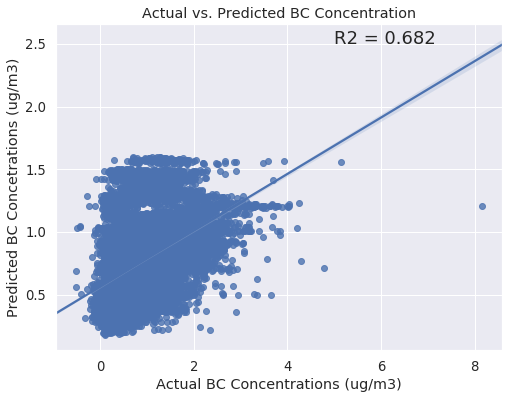

In [267]:
# Creating a plot of BC concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = BC.BC_Value, y = BC_OLS_corr_results.fittedvalues, fit_reg=True)
ax.set(xlabel = 'Actual BC Concentrations (ug/m3)', ylabel = 'Predicted BC Concetrations (ug/m3)')
plt.title('Actual vs. Predicted BC Concentration')
plt.text(5 , 2.5 ,"R2 = 0.682", fontsize = 18)


The above plot shows that the simple linear model does a decent job of predicting concentrations below 2 ug/m3, but does not perform well at high concentrations. 

<b> <font size = 4> NO2 Dataset </b> </font>

In [268]:
NO2_features_corr = NO2_features.corr()
NO2_features_OLS = features_high_corr(NO2_features_corr)
print("Features in NO2 dataset that are not highly correlated: ")
print(NO2_features_OLS)

Features in NO2 dataset that are not highly correlated: 
Index(['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-FoodPlant-340611_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections'],
      dtype='object')


In [359]:
#Create a dataframe with NO2 value and selected columns from Lasso
OLS_NO2_df = NO2[['NO2_Value']].join(NO2[['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-FoodPlant-340611_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections']])

In [360]:
## Plot Correlation matrix
OLS_NO2_df_corr = OLS_NO2_df.corr()
NO2_features_corr_mat = OLS_NO2_df_corr.as_matrix()


module://ipykernel.pylab.backend_inline


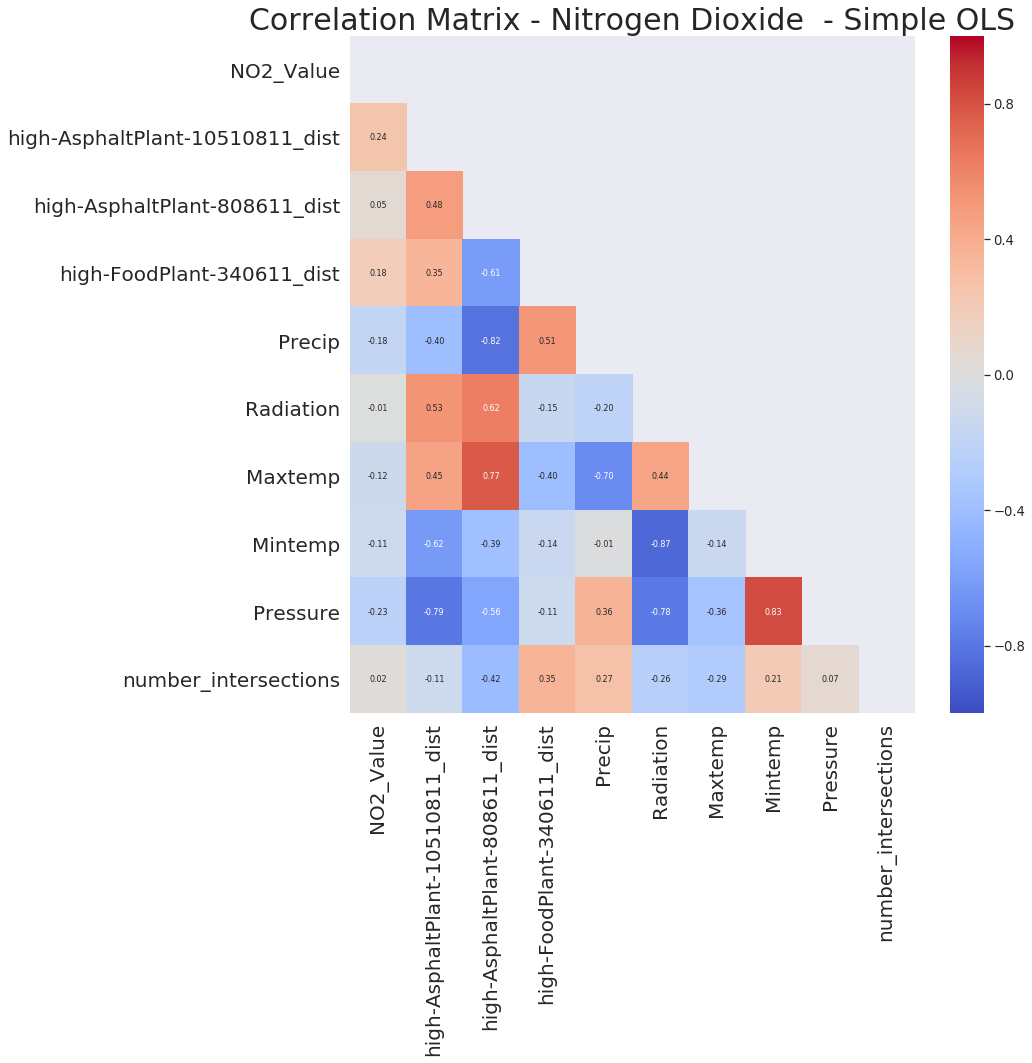

In [361]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
NO2_features_corr_mat[np.triu_indices_from(NO2_features_corr_mat)] = np.nan

fig, ax = plt.subplots(figsize=(15, 15))

hm = sns.heatmap(NO2_features_corr_mat, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(OLS_NO2_df_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(OLS_NO2_df_corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(OLS_NO2_df_corr.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Nitrogen Dioxide  - Simple OLS', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

In [269]:
## Fit an OLS on the remaining features
NO2_OLS_corr_model = sm.OLS(NO2['NO2_Value'], NO2_features[NO2_features_OLS])
NO2_OLS_corr_results = NO2_OLS_corr_model.fit() 
NO2_OLS_corr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              NO2_Value   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.818
Method:                 Least Squares   F-statistic:                          1.075e+04
Date:                Sun, 31 May 2020   Prob (F-statistic):                        0.00
Time:                        22:21:58   Log-Likelihood:                         -76254.
No. Observations:               21488   AIC:                                  1.525e+05
Df Residuals:                   21479   BIC:                                  1.526e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
high-AsphaltPlant-10510811_dist     0.1445      0.072      2.017      0.044       0.004       0.285
high-AsphaltPlant-808611_dist      -0.1970      0.057     -3.447      0.001      -0.309      -0.085
high-FoodPlant-340611_dist          0.9573      0.057     16.924      0.000       0.846       1.068
Precip                            -43.8396      1.213    -36.156      0.000     -46.216     -41.463
Radiation                           1.6794      0.038     43.681      0.000       1.604       1.755
Maxtemp                           -29.0032      0.610    -47.551      0.000     -30.199     -27.808
Mintemp                             8.8408      2.111      4.189      0.000       4.704      12.978
Pressure                            0.0129      0.029      0.442      0.658      -0.044       0.070
number_intersections               -0.0728      0.011     -6.411      0.000      -0.095      -0.051
==============================================================================
Omnibus:                     1881.925   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2437.379
Skew:                           0.772   Prob(JB):                         0.00
Kurtosis:                       3.579   Cond. No.                     3.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [270]:
## R2, Coefficient and Intercept
print("The R2 is {}".format(NO2_OLS_corr_results.rsquared), "The R2 tells us that there is a correlation between the features identified and concentration. ")

The R2 is 0.8183457629742368 The R2 tells us that there is a correlation between the features identified and concentration. 


Text(46, 29, 'R2 = 0.818')

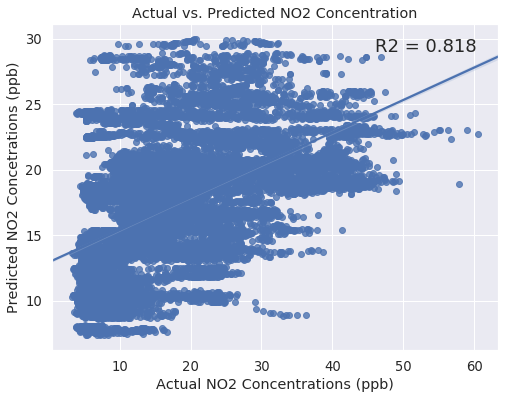

In [271]:
# Creating a plot of NO2 concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = NO2.NO2_Value, y = NO2_OLS_corr_results.fittedvalues, fit_reg=True)
ax.set(xlabel = 'Actual NO2 Concentrations (ppb)', ylabel = 'Predicted NO2 Concetrations (ppb)')
plt.title('Actual vs. Predicted NO2 Concentration')
plt.text(46 , 29 ,"R2 = 0.818", fontsize = 18)


Once again, the above plot shows that the simple linear model does a decent job of predicting concentrations below 30 ppb, but does not perform well at high concentrations. 

<b> <font size = 5> Plotting a histogram of all features </b> </font>

<b> <font size = 3> BC dataset </b> </font>

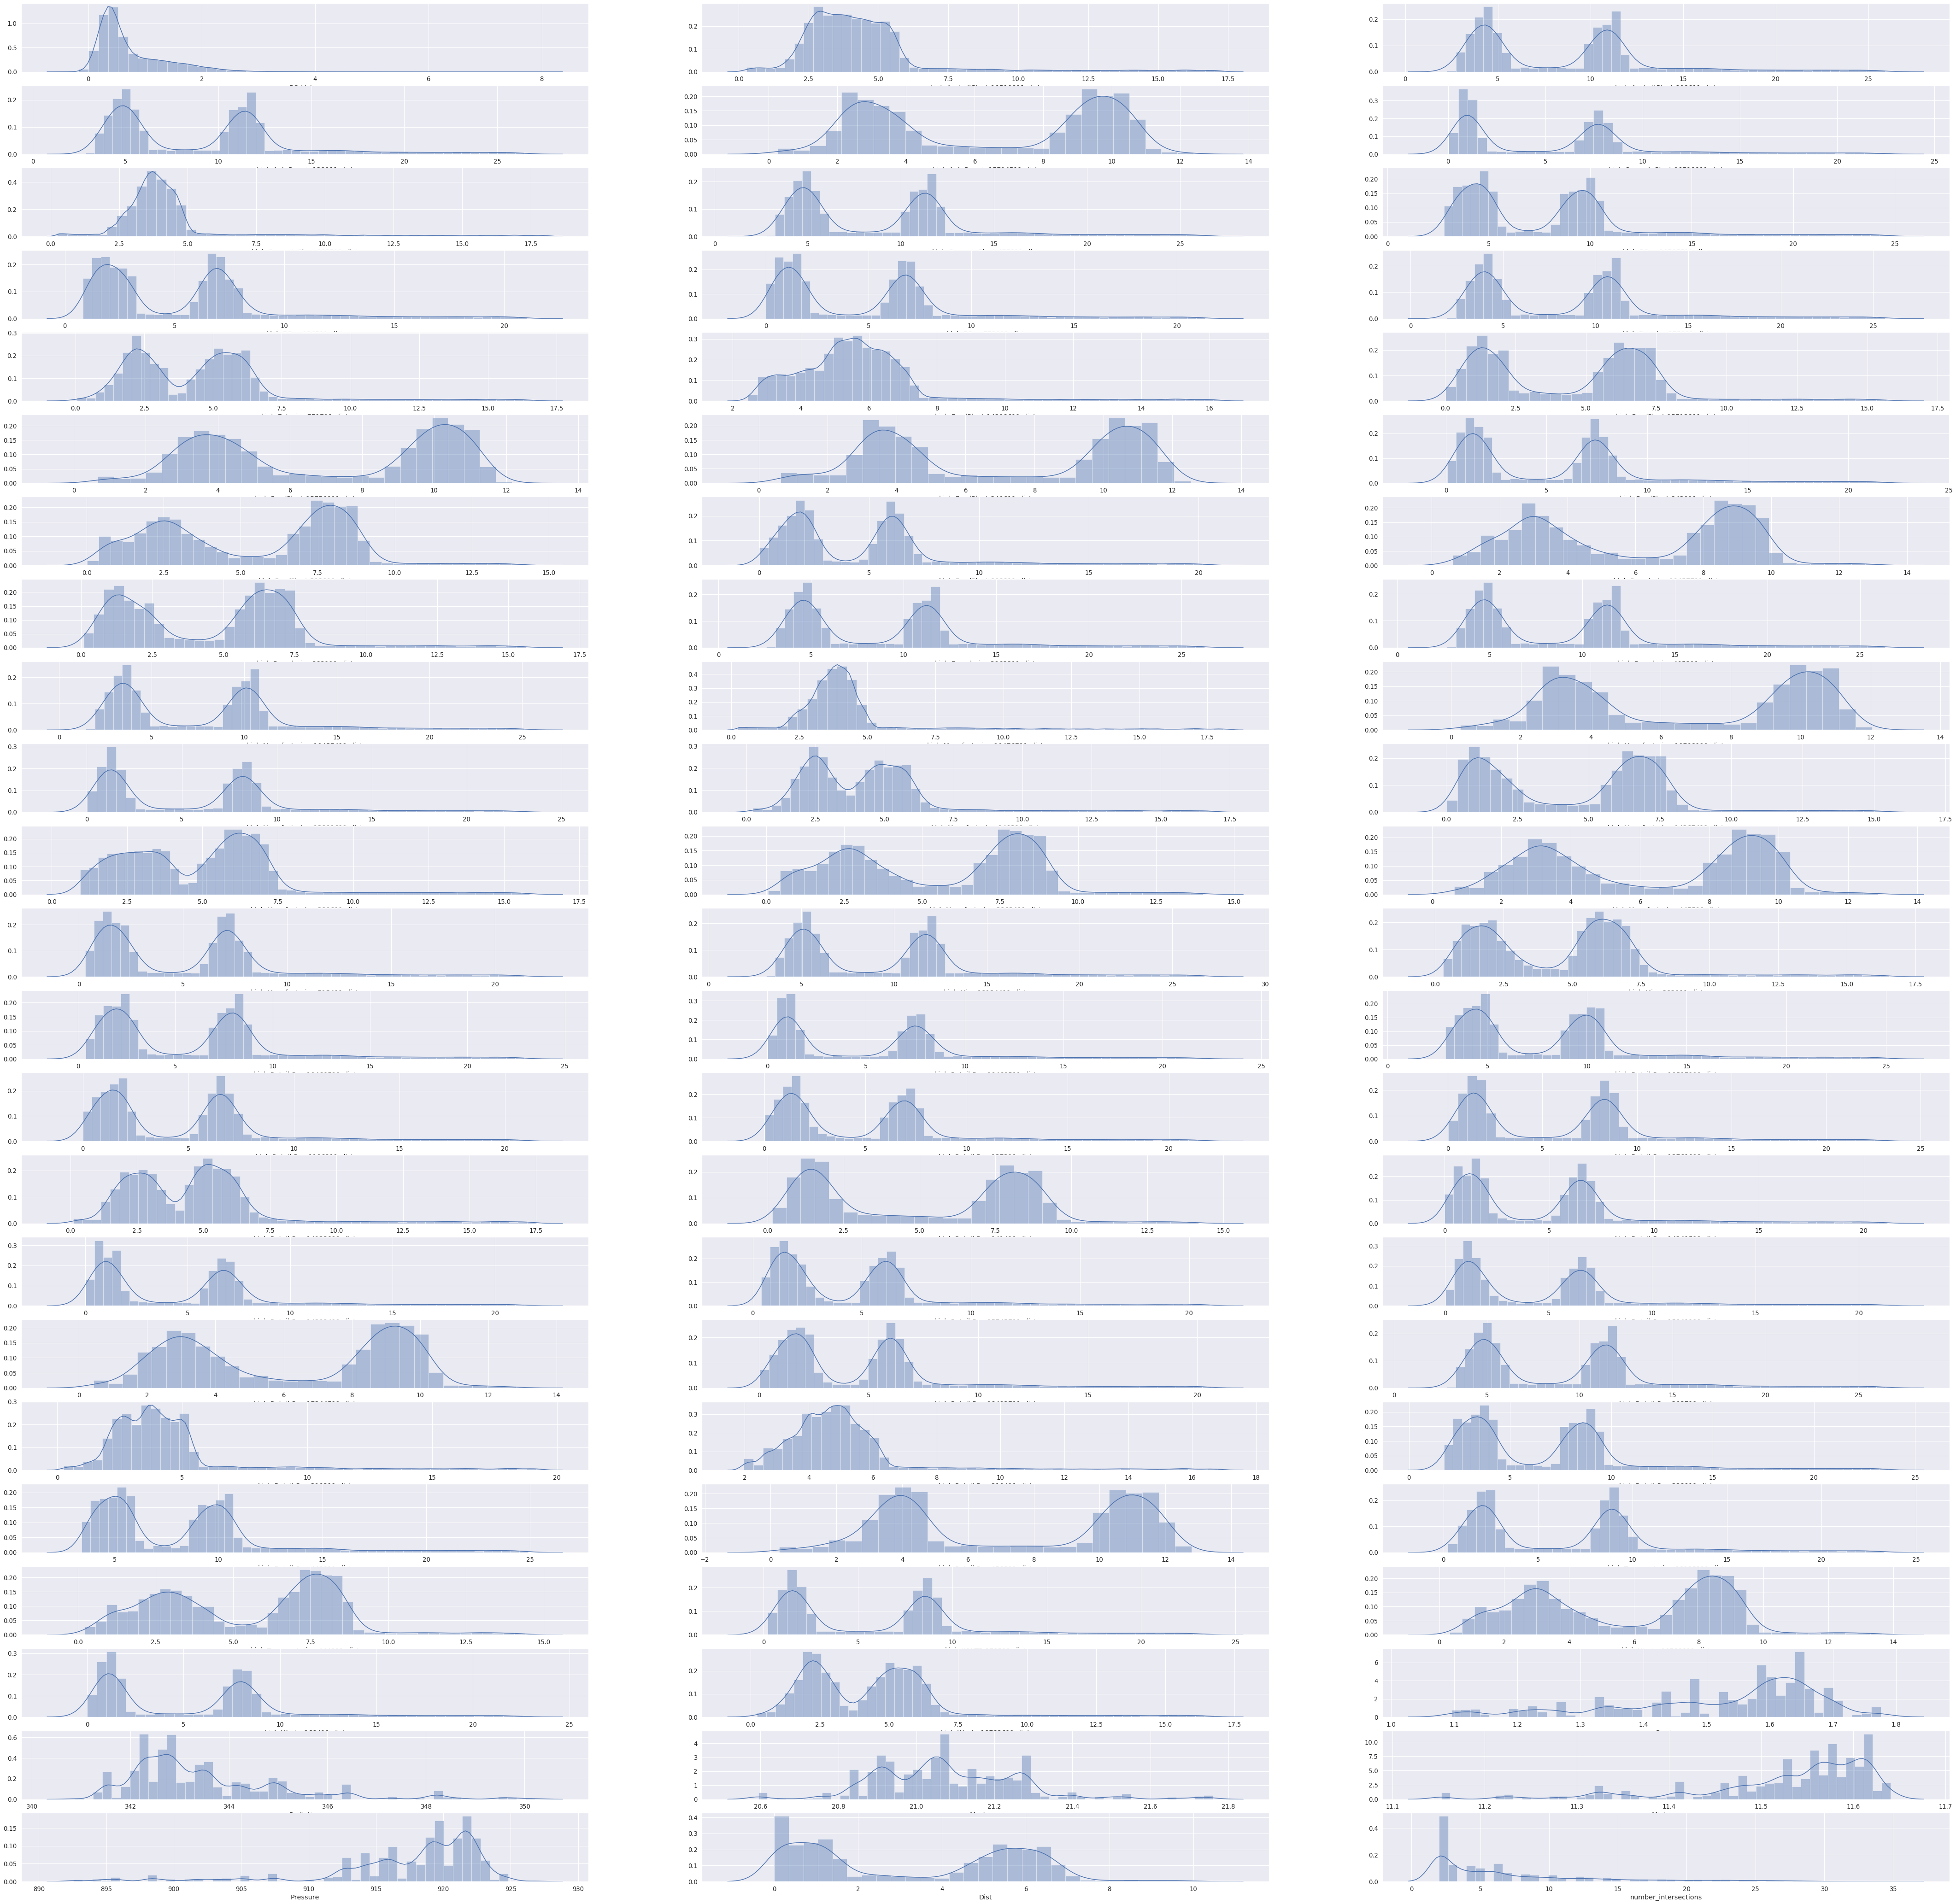

In [272]:
fig, axes = plt.subplots(nrows=23, ncols=3, figsize = (75,75))
for i, column in enumerate(BC.columns):
    sns.distplot(BC[column],ax=axes[i//3, i%3])

<b> <font size = 3> NO2 dataset </b> </font>

In [ ]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize = (75,75))
for i, column in enumerate(NO2.columns):
    sns.distplot(NO2[column],ax=axes[i//3, i%3])

Based on a histogram of all features in the BC and NO2 dataset, we see that none of the features follow a normal distribution. We use a box-cox transformation to fix skewed features.

<b> <font size = 4> Performing a box-cox transformation </b> </font>

In [273]:
# First make a copy of each dataframe and apply transformation on copy
BC_df_copy = BC.copy()
NO2_df_copy = NO2.copy()

In [274]:
lambdas_BC = pd.DataFrame(columns = ['Column_name', "Lambda"])
lambdas_NO2 = pd.DataFrame(columns = ['Column_name', "Lambda"])
def boxcox_transform(df):
    lambdas_df = pd.DataFrame(columns = ['Column_name', "Lambda"])
    for column in df.columns:
        if df[column].min() <=0 :
            df[column] = df[column] - df[column].min() + 0.01
        df[column], boxcox_lambda = boxcox(df[column])
        lambdas_df = lambdas_df.append({'Column_name': column, 'Lambda':boxcox_lambda}, ignore_index = True)
    return lambdas_df

In [275]:
lambdas_BC = boxcox_transform(BC_df_copy)
lambas_NO2 = boxcox_transform(NO2_df_copy)

In [ ]:
fig, axes = plt.subplots(nrows=23, ncols=3, figsize = (75,75))
for i, column in enumerate(BC_df_copy.columns):
    sns.distplot(BC_df_copy[column],ax=axes[i//3, i%3])

In [ ]:
fig, axes = plt.subplots(nrows=23, ncols=3, figsize = (75,75))
for i, column in enumerate(NO2_df_copy.columns):
    sns.distplot(NO2_df_copy[column],ax=axes[i//3, i%3])

<b> <font size = 5> Recreate the dataframes with normalized X and Y, and standardize the data </b> </font>

In [276]:
#BC Dataset
y_BC = BC_df_copy[['BC_Value']]
X_BC = BC_df_copy.drop(columns = ['BC_Value'])
X_BC_scaled = pd.DataFrame(StandardScaler().fit_transform(X_BC), index = X_BC.index, columns = X_BC.columns)

In [277]:
#BC Dataset
y_NO2 = NO2_df_copy[['NO2_Value']]
X_NO2 = NO2_df_copy.drop(columns = ['NO2_Value'])
X_NO2_scaled = pd.DataFrame(StandardScaler().fit_transform(X_NO2), index = X_NO2.index, columns = X_NO2.columns)

<b> <font size = 5> Lasso Regularization with Gridsearch </b> </font>

In [278]:
# First define a function to calculate scores for a model

def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=10,
                             scoring='r2')
    
    return('CV Mean: ', np.mean(scores), 'STD: ', np.std(scores))


<font size = 4> <b>  BC dataset
</b> </font>

In [279]:
# First set up the test-train split
X_train_BC, X_test_BC, y_train_BC, y_test_BC = train_test_split(X_BC_scaled, y_BC, test_size=0.30, random_state=0)

In [280]:
# Train model with default alpha=1
lasso_BC = Lasso(alpha=1).fit(X_train_BC, y_train_BC)

# get cross val scores
get_cv_scores(lasso_BC, X_train_BC, y_train_BC)

('CV Mean: ', -0.0006961926159118059, 'STD: ', 0.0011057797886150414)

In [281]:
##Instantiate a Lasso Regularization model. Performe a LassoCV using 5-fold cross validation
lassoCV_BC = LassoCV(cv=5, alphas= None)

#Fit the model to BC X and y
lassoCV_BC.fit(X_train_BC, y_train_BC)

### Set the parameters
lasso_BC.set_params(alpha=lassoCV_BC.alpha_)

#Print the optimal valu for alpha that gives the best fit for training data
print("Best Alpha using LassoCV = ", lassoCV_BC.alpha_)


#Using this value of alpha to refit the model
lasso_BC.fit(X_train_BC, y_train_BC)


## Computing mean squared error on the test data
print("MSE on test data = ", mean_squared_error(y_test_BC, lasso_BC.predict(X_test_BC)))

## Best score using Lasso CV 
print("Best score using LassoCV: ", lasso_BC.score(X_test_BC, y_test_BC))

#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef_BC = pd.Series(lasso_BC.coef_, index = BC_features.columns)


Best Alpha using LassoCV =  0.00015274253372807208
MSE on test data =  0.07799639454945655
Best score using LassoCV:  0.5345421171448599


In [282]:
#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef_BC = pd.Series(lasso_BC.coef_, index = X_BC.columns)

Text(0.5, 1.0, 'Feature importance using Lasso Model for BC Dataset')

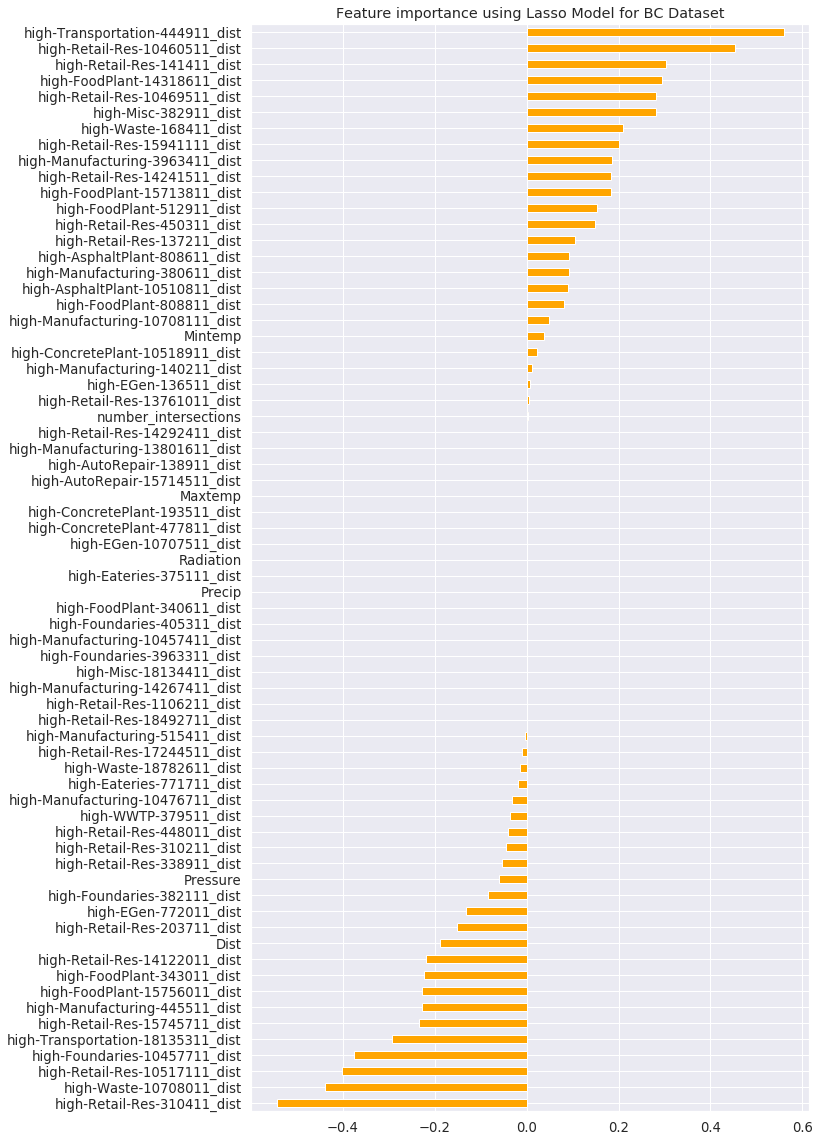

In [283]:
#Display feature importance using Lasso model

#Sort the features
imp_coef = coef_BC.sort_values()

# Plot feature importance in  bar graph
plt.figure(figsize = (10,20))
imp_coef.plot(kind = "barh", color='orange')
plt.title("Feature importance using Lasso Model for BC Dataset")

<b> <font size = 3> Fit an OLS on the features that were selected </b> </font>

In [284]:
coef_BC[coef_BC !=0].index

Index(['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-ConcretePlant-10518911_dist', 'high-EGen-136511_dist',
       'high-EGen-772011_dist', 'high-Eateries-771711_dist',
       'high-FoodPlant-14318611_dist', 'high-FoodPlant-15713811_dist',
       'high-FoodPlant-15756011_dist', 'high-FoodPlant-343011_dist',
       'high-FoodPlant-512911_dist', 'high-FoodPlant-808811_dist',
       'high-Foundaries-10457711_dist', 'high-Foundaries-382111_dist',
       'high-Manufacturing-10476711_dist', 'high-Manufacturing-10708111_dist',
       'high-Manufacturing-140211_dist', 'high-Manufacturing-380611_dist',
       'high-Manufacturing-3963411_dist', 'high-Manufacturing-445511_dist',
       'high-Manufacturing-515411_dist', 'high-Misc-382911_dist',
       'high-Retail-Res-10460511_dist', 'high-Retail-Res-10469511_dist',
       'high-Retail-Res-10517111_dist', 'high-Retail-Res-137211_dist',
       'high-Retail-Res-13761011_dist', 'high-Retail-Res-14122011_dist',
     

In [285]:
## Fit an OLS on the remaining features
BC_OLS_Lasso = sm.OLS(BC['BC_Value'], BC_features[coef_BC[coef_BC !=0].index])
BC_OLS_Lasso_results = BC_OLS_Lasso.fit() 
BC_OLS_Lasso_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               BC_Value   R-squared (uncentered):                   0.827
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                              2099.
Date:                Sun, 31 May 2020   Prob (F-statistic):                        0.00
Time:                        22:22:37   Log-Likelihood:                         -10408.
No. Observations:               21488   AIC:                                  2.091e+04
Df Residuals:                   21439   BIC:                                  2.131e+04
Df Model:                          49                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
high-AsphaltPlant-10510811_dist       4.0567      0.436      9.295      0.000       3.201       4.912
high-AsphaltPlant-808611_dist       -41.9524      3.269    -12.835      0.000     -48.359     -35.546
high-ConcretePlant-10518911_dist     -1.0495      0.095    -11.074      0.000      -1.235      -0.864
high-EGen-136511_dist                 4.4218      0.398     11.120      0.000       3.642       5.201
high-EGen-772011_dist                -0.9109      0.106     -8.580      0.000      -1.119      -0.703
high-Eateries-771711_dist             4.5713      0.659      6.935      0.000       3.279       5.863
high-FoodPlant-14318611_dist         15.2293      1.193     12.762      0.000      12.890      17.568
high-FoodPlant-15713811_dist         -0.3450      0.094     -3.684      0.000      -0.529      -0.161
high-FoodPlant-15756011_dist         -2.8975      0.524     -5.528      0.000      -3.925      -1.870
high-FoodPlant-343011_dist           -1.6590      0.178     -9.327      0.000      -2.008      -1.310
high-FoodPlant-512911_dist           -4.0435      0.833     -4.851      0.000      -5.677      -2.410
high-FoodPlant-808811_dist            0.5232      0.082      6.355      0.000       0.362       0.685
high-Foundaries-10457711_dist        -4.4442      1.363     -3.260      0.001      -7.116      -1.772
high-Foundaries-382111_dist           0.2678      0.113      2.372      0.018       0.047       0.489
high-Manufacturing-10476711_dist      3.1388      0.230     13.655      0.000       2.688       3.589
high-Manufacturing-10708111_dist      0.4735      0.197      2.408      0.016       0.088       0.859
high-Manufacturing-140211_dist        1.2277      0.833      1.474      0.140      -0.405       2.860
high-Manufacturing-380611_dist        2.2972      0.328      7.010      0.000       1.655       2.939
high-Manufacturing-3963411_dist      10.2872      1.892      5.437      0.000       6.579      13.996
high-Manufacturing-445511_dist       21.6157      4.852      4.455      0.000      12.106      31.125
high-Manufacturing-515411_dist       -1.4269      0.419     -3.407      0.001      -2.248      -0.606
high-Misc-382911_dist                 0.2670      0.038      7.094      0.000       0.193       0.341
high-Retail-Res-10460511_dist         1.4084      0.284      4.966      0.000       0.852       1.964
high-Retail-Res-10469511_dist         1.7054      0.103     16.523      0.000       1.503       1.908
high-Retail-Res-10517111_dist        35.1287      3.896      9.016      0.000      27.492      42.766
high-Retail-Res-137211_dist           0.8309      0.080     10.365      0.000       0.674       0.988
high-Retail-Res-13761011_d

Text(5, 5, 'R2 = 0.827')

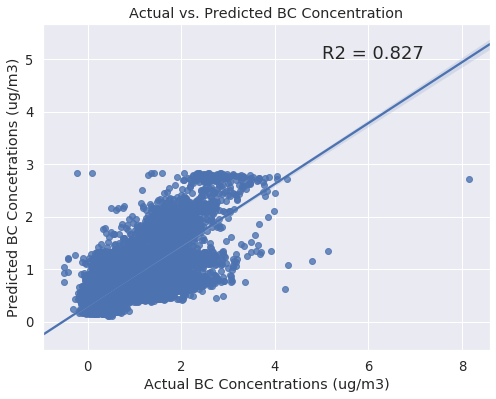

In [286]:
# Creating a plot of BC concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = BC.BC_Value, y = BC_OLS_Lasso_results.fittedvalues, fit_reg=True)
ax.set(xlabel = 'Actual BC Concentrations (ug/m3)', ylabel = 'Predicted BC Concetrations (ug/m3)')
plt.title('Actual vs. Predicted BC Concentration')
plt.text(5 , 5 ,"R2 = 0.827", fontsize = 18)


This model does much better than the model that was developed just based on features that were not highly correlated. Predicted values for high concentration measurements are still pretty poor.

In [287]:
#Create a dataframe with BC value and selected columns from Lasso
Lasso_BC_df = BC[['BC_Value']].join(BC_features[coef_BC[coef_BC !=0].index])

In [288]:
Lasso_BC_corr = Lasso_BC_df.corr()
arr_corr_BC= Lasso_BC_corr.as_matrix()

module://ipykernel.pylab.backend_inline


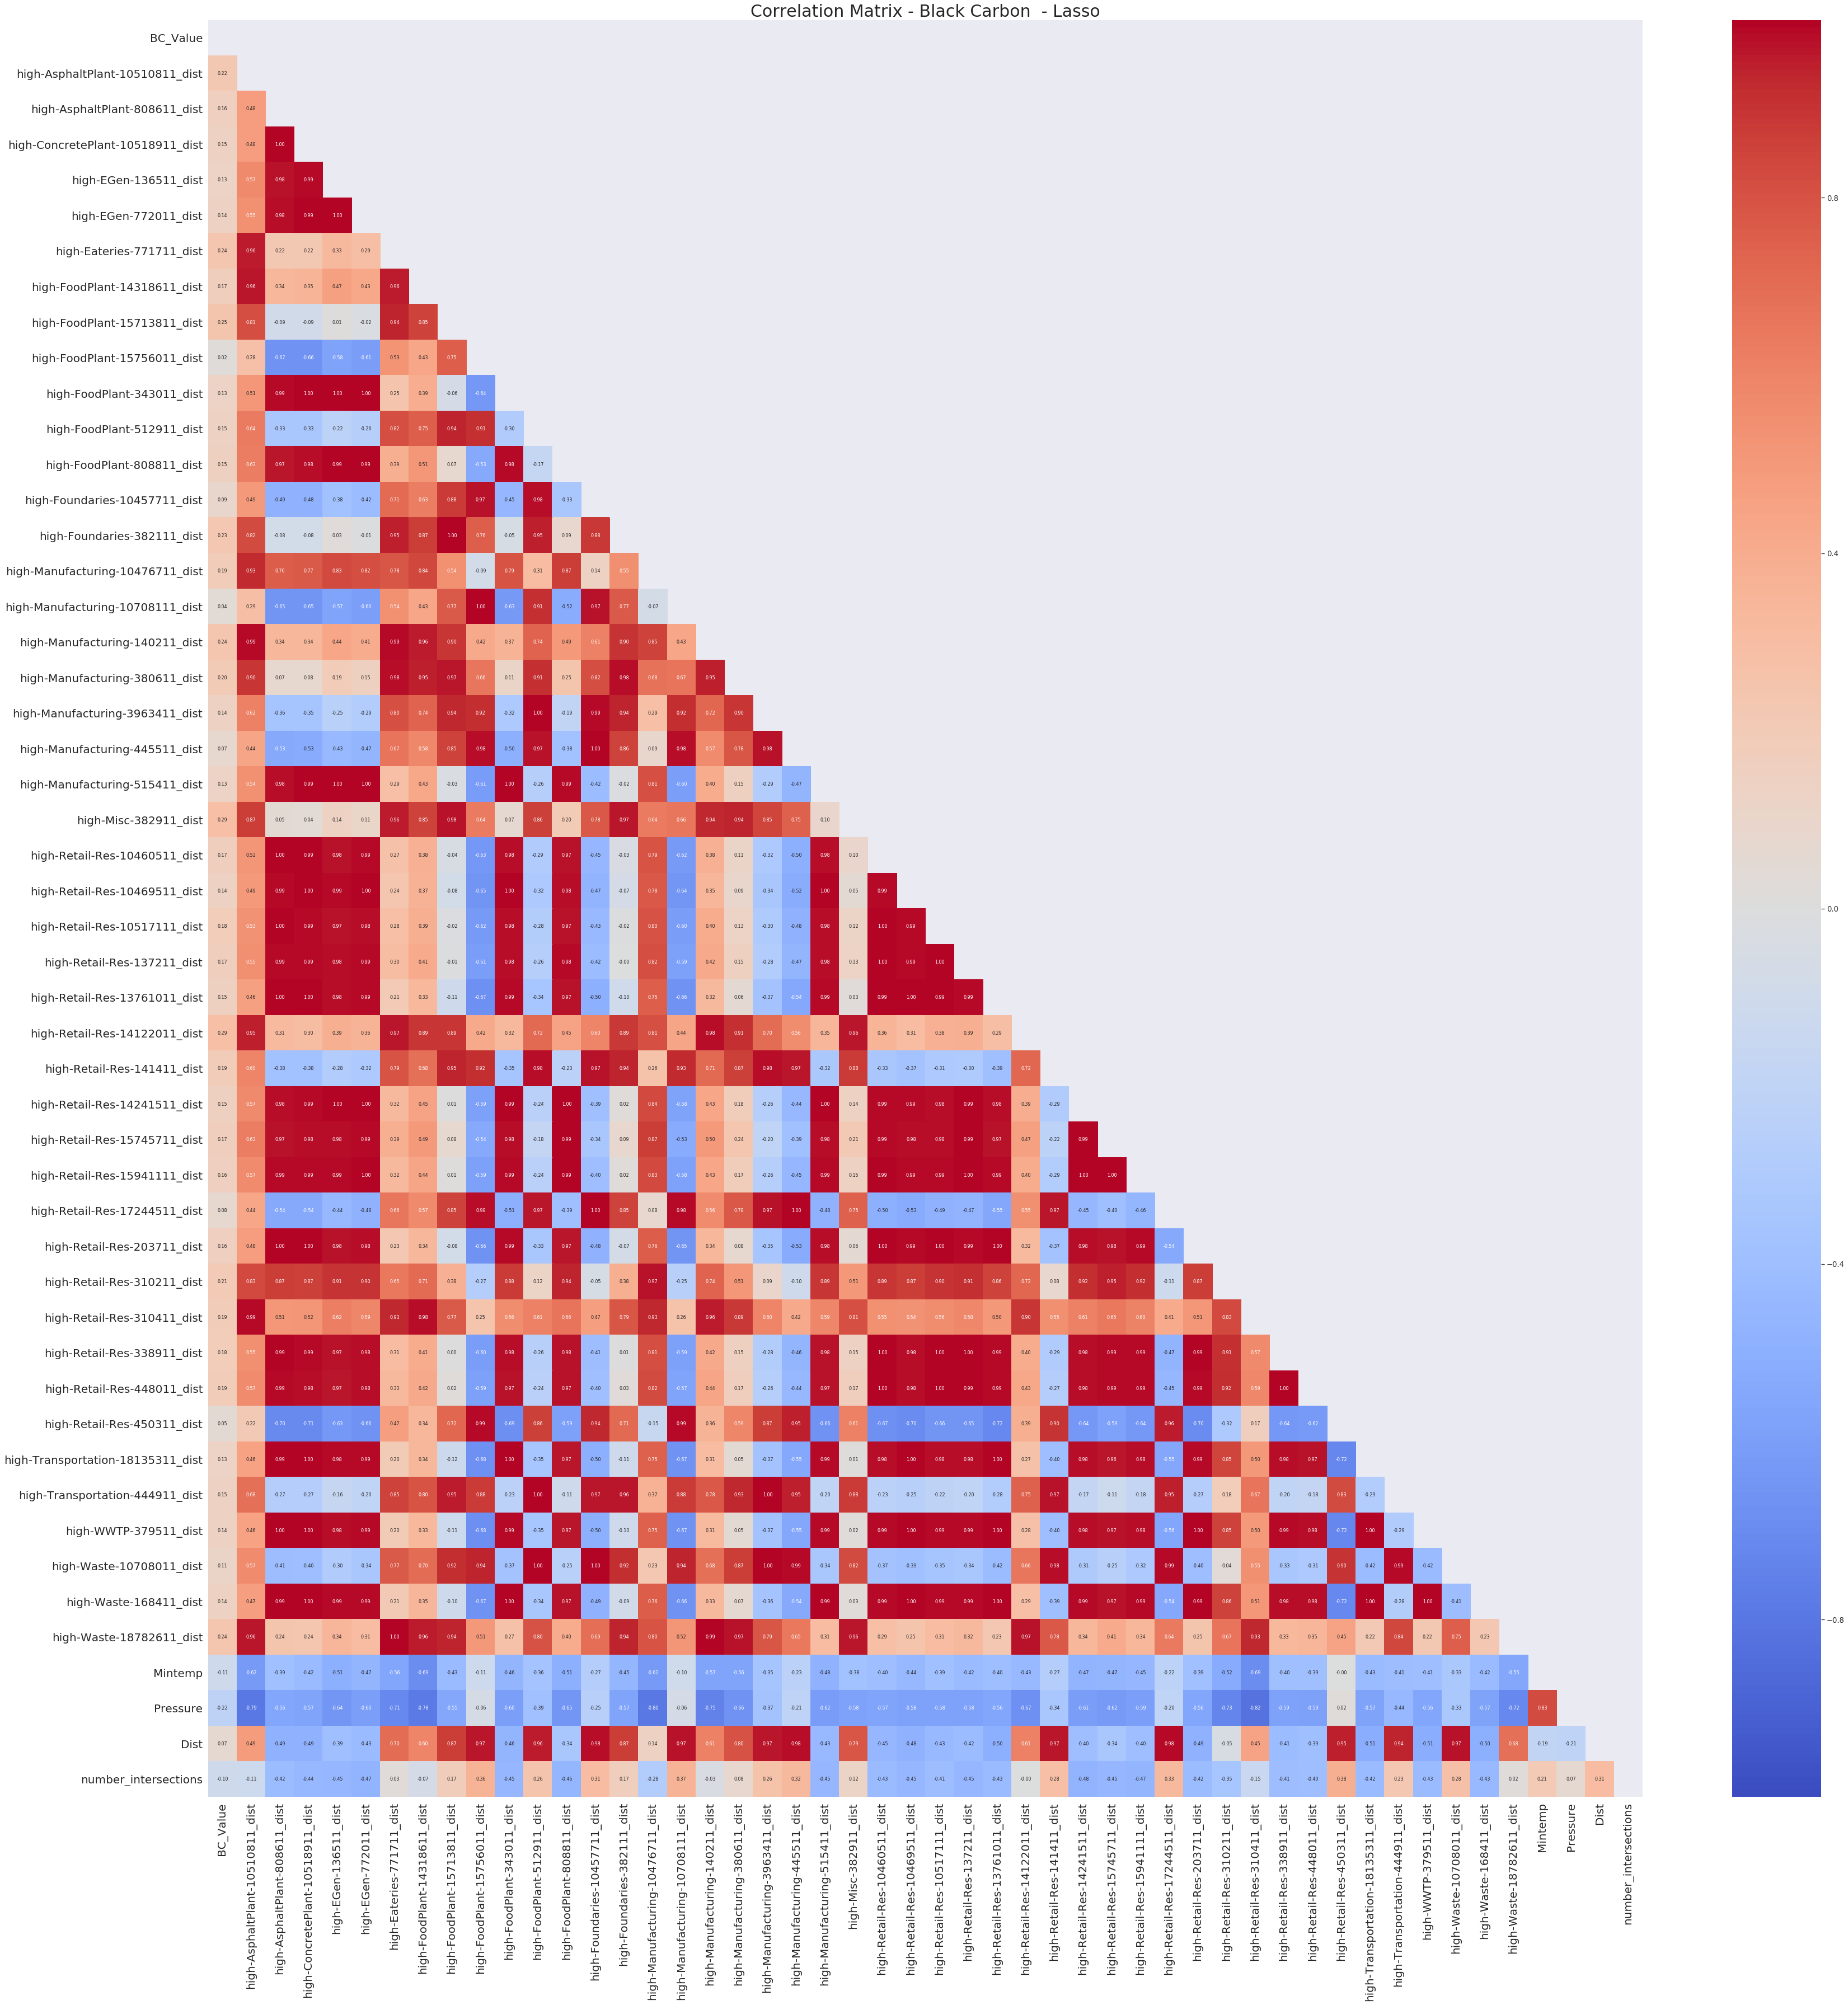

In [289]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr_BC[np.triu_indices_from(arr_corr_BC)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr_BC, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(Lasso_BC_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(Lasso_BC_corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(Lasso_BC_corr.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Black Carbon  - Lasso', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

<font size = 4> <b>  NO2 dataset
</b> </font>

In [290]:
# First set up the test-train split
X_train_NO2, X_test_NO2, y_train_NO2, y_test_NO2 = train_test_split(X_NO2_scaled, y_NO2, test_size=0.30, random_state=0)

In [291]:
# Train model with default alpha=1
lasso_NO2 = Lasso(alpha=1).fit(X_train_NO2, y_train_NO2)

# get cross val scores
get_cv_scores(lasso_NO2, X_train_NO2, y_train_NO2)

('CV Mean: ', -0.0005128911866175035, 'STD: ', 0.0006258654727031758)

In [292]:
##Instantiate a Lasso Regularization model. Performe a LassoCV using 5-fold cross validation
lassoCV_NO2 = LassoCV(cv=5, alphas= None)

#Fit the model to BC X and y
lassoCV_NO2.fit(X_train_NO2, y_train_NO2)

### Set the parameters
lasso_NO2.set_params(alpha=lassoCV_NO2.alpha_)

#Print the optimal valu for alpha that gives the best fit for training data
print("Best Alpha using LassoCV = ", lassoCV_NO2.alpha_)


#Using this value of alpha to refit the model
lasso_NO2.fit(X_train_NO2, y_train_NO2)


## Computing mean squared error on the test data
print("MSE on test data = ", mean_squared_error(y_test_NO2, lasso_NO2.predict(X_test_NO2)))

## Best score using Lasso CV 
print("Best score using LassoCV: ", lasso_NO2.score(X_test_NO2, y_test_NO2))

#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef_NO2 = pd.Series(lasso_NO2.coef_, index = NO2_features.columns)


Best Alpha using LassoCV =  0.00038952008419926016
MSE on test data =  0.20860434953284926
Best score using LassoCV:  0.6395777236551858


In [293]:
#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef_NO2 = pd.Series(lasso_NO2.coef_, index = X_NO2.columns)
coef_NO2

high-AsphaltPlant-10510811_dist     0.335146
high-AsphaltPlant-808611_dist      -0.849131
high-AutoRepair-195711_dist        -0.000000
high-EGen-10707511_dist            -0.000000
high-EGen-136511_dist               0.239457
high-Eateries-375111_dist          -0.178591
high-Eateries-771711_dist           0.025465
high-FoodPlant-14318611_dist       -0.000000
high-FoodPlant-340611_dist         -0.000000
high-FoodPlant-512911_dist          0.567633
high-FoodPlant-804911_dist         -0.610777
high-FoodPlant-808811_dist          0.003412
high-Foundaries-382111_dist        -0.000000
high-Foundaries-405311_dist        -0.000000
high-Manufacturing-10457511_dist    0.042460
high-Manufacturing-13983311_dist    0.407820
high-Manufacturing-140211_dist      0.189898
high-Manufacturing-14071611_dist   -0.252389
high-Manufacturing-14182811_dist   -0.000000
high-Manufacturing-14267411_dist    0.000754
high-Manufacturing-3963411_dist     0.014484
high-Manufacturing-445511_dist      0.000000
high-Manuf

Text(0.5, 1.0, 'Feature importance using Lasso Model for NO2 Dataset')

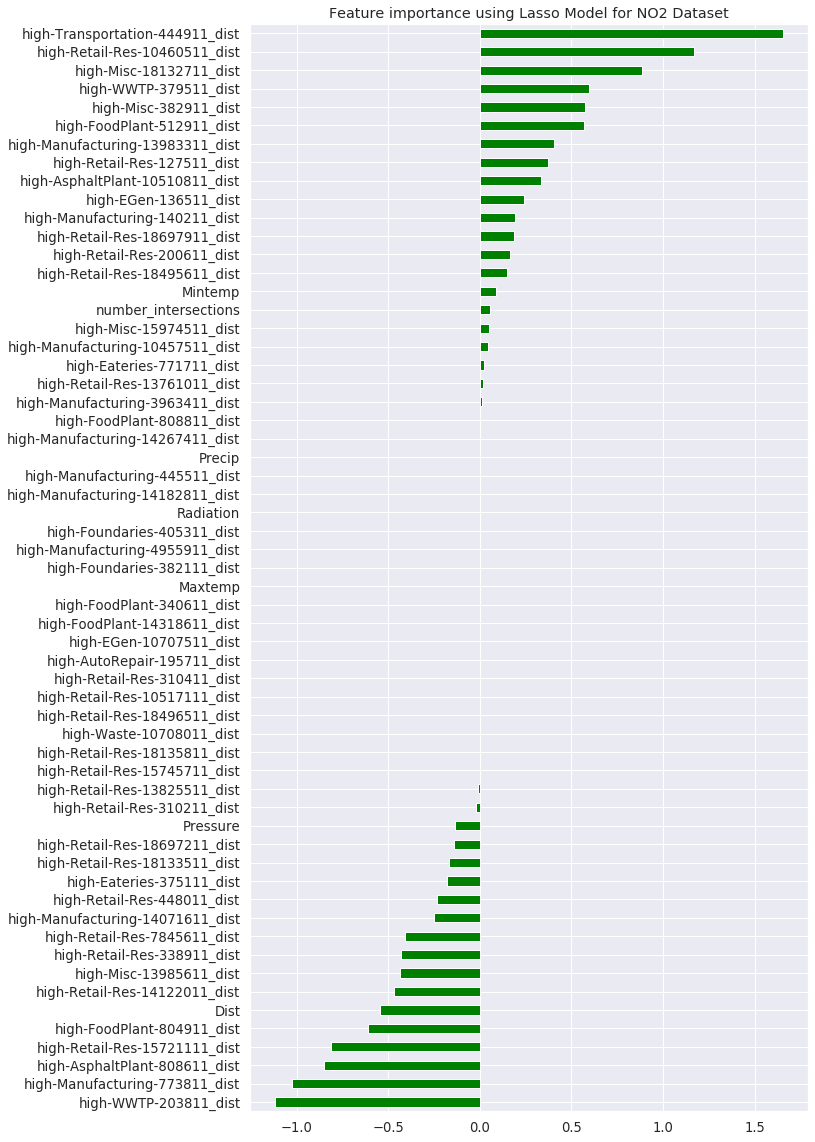

In [294]:
#Display feature importance using Lasso model

#Sort the features
imp_coef = coef_NO2.sort_values()

# Plot feature importance in  bar graph
plt.figure(figsize = (10,20))
imp_coef.plot(kind = "barh", color='green')
plt.title("Feature importance using Lasso Model for NO2 Dataset")

<b> <font size = 3> Fit an OLS on the features that were selected </b> </font>

In [295]:
coef_NO2[coef_NO2 !=0].index

Index(['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist',
       'high-EGen-136511_dist', 'high-Eateries-375111_dist',
       'high-Eateries-771711_dist', 'high-FoodPlant-512911_dist',
       'high-FoodPlant-804911_dist', 'high-FoodPlant-808811_dist',
       'high-Manufacturing-10457511_dist', 'high-Manufacturing-13983311_dist',
       'high-Manufacturing-140211_dist', 'high-Manufacturing-14071611_dist',
       'high-Manufacturing-14267411_dist', 'high-Manufacturing-3963411_dist',
       'high-Manufacturing-773811_dist', 'high-Misc-13985611_dist',
       'high-Misc-15974511_dist', 'high-Misc-18132711_dist',
       'high-Misc-382911_dist', 'high-Retail-Res-10460511_dist',
       'high-Retail-Res-127511_dist', 'high-Retail-Res-13761011_dist',
       'high-Retail-Res-13825511_dist', 'high-Retail-Res-14122011_dist',
       'high-Retail-Res-15721111_dist', 'high-Retail-Res-18133511_dist',
       'high-Retail-Res-18495611_dist', 'high-Retail-Res-18697211_dist',
       'high-

In [296]:
## Fit an OLS on the remaining features
NO2_OLS_Lasso = sm.OLS(NO2['NO2_Value'], NO2_features[coef_NO2[coef_NO2 !=0].index])
NO2_OLS_Lasso_results = NO2_OLS_Lasso.fit() 
NO2_OLS_Lasso_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              NO2_Value   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              5268.
Date:                Sun, 31 May 2020   Prob (F-statistic):                        0.00
Time:                        22:22:50   Log-Likelihood:                         -68511.
No. Observations:               21488   AIC:                                  1.371e+05
Df Residuals:                   21446   BIC:                                  1.374e+05
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
high-AsphaltPlant-10510811_dist     32.3134      2.068     15.622      0.000      28.259      36.368
high-AsphaltPlant-808611_dist    -8249.1066   1179.534     -6.994      0.000   -1.06e+04   -5937.132
high-EGen-136511_dist               37.1751      3.570     10.413      0.000      30.178      44.173
high-Eateries-375111_dist         4945.4679    731.520      6.761      0.000    3511.634    6379.301
high-Eateries-771711_dist          -16.3971      3.835     -4.276      0.000     -23.913      -8.881
high-FoodPlant-512911_dist         -74.7029     11.637     -6.420      0.000     -97.512     -51.894
high-FoodPlant-804911_dist         -39.5776      4.700     -8.421      0.000     -48.789     -30.366
high-FoodPlant-808811_dist         -11.2241      2.503     -4.483      0.000     -16.131      -6.317
high-Manufacturing-10457511_dist     9.1533      2.327      3.934      0.000       4.593      13.714
high-Manufacturing-13983311_dist    13.4396      0.718     18.713      0.000      12.032      14.847
high-Manufacturing-140211_dist      32.5681      4.404      7.395      0.000      23.936      41.201
high-Manufacturing-14071611_dist   732.8911     86.306      8.492      0.000     563.725     902.057
high-Manufacturing-14267411_dist    -4.7073      1.479     -3.182      0.001      -7.607      -1.808
high-Manufacturing-3963411_dist    148.9537     25.301      5.887      0.000      99.362     198.545
high-Manufacturing-773811_dist     -81.1912      3.262    -24.888      0.000     -87.586     -74.797
high-Misc-13985611_dist            -17.7073      2.432     -7.281      0.000     -22.474     -12.940
high-Misc-15974511_dist            -18.6592      2.763     -6.753      0.000     -24.075     -13.243
high-Misc-18132711_dist             18.4679      1.443     12.794      0.000      15.639      21.297
high-Misc-382911_dist                2.1365      0.513      4.166      0.000       1.131       3.142
high-Retail-Res-10460511_dist       -8.7317      6.954     -1.256      0.209     -22.363       4.900
high-Retail-Res-127511_dist          3.4740      1.077      3.225      0.001       1.362       5.586
high-Retail-Res-13761011_dist       -8.7124      1.868     -4.664      0.000     -12.374      -5.051
high-Retail-Res-13825511_dist     -549.0568     80.329     -6.835      0.000    -706.508    -391.605
high-Retail-Res-14122011_dist       -4.4559      0.681     -6.539      0.000      -5.792      -3.120
high-Retail-Res-15721111_dist      -52.3147      3.257    -16.060      0.000     -58.699     -45.930
high-Retail-Res-18133511_dist        7.1740      4.101      1.749      0.080      -0.864      15.212
high-Retail-Res-18495611_dist        5.0519      1.102 

Text(50, 5, 'R2 = 0.912')

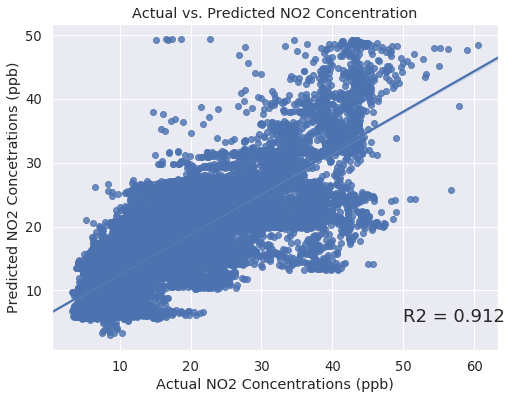

In [297]:
# Creating a plot of NO2 concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = NO2.NO2_Value, y = NO2_OLS_Lasso_results.fittedvalues, fit_reg=True)
ax.set(xlabel = 'Actual NO2 Concentrations (ppb)', ylabel = 'Predicted NO2 Concetrations (ppb)')
plt.title('Actual vs. Predicted NO2 Concentration')
plt.text(50 , 5 ,"R2 = 0.912", fontsize = 18)


In [298]:
#Create a dataframe with NO2 value and selected columns from Lasso
Lasso_NO2_df = NO2[['NO2_Value']].join(NO2_features[coef_NO2[coef_NO2 !=0].index])

In [299]:
Lasso_NO2_corr = Lasso_NO2_df.corr()
arr_corr_NO2= Lasso_NO2_corr.as_matrix()

module://ipykernel.pylab.backend_inline


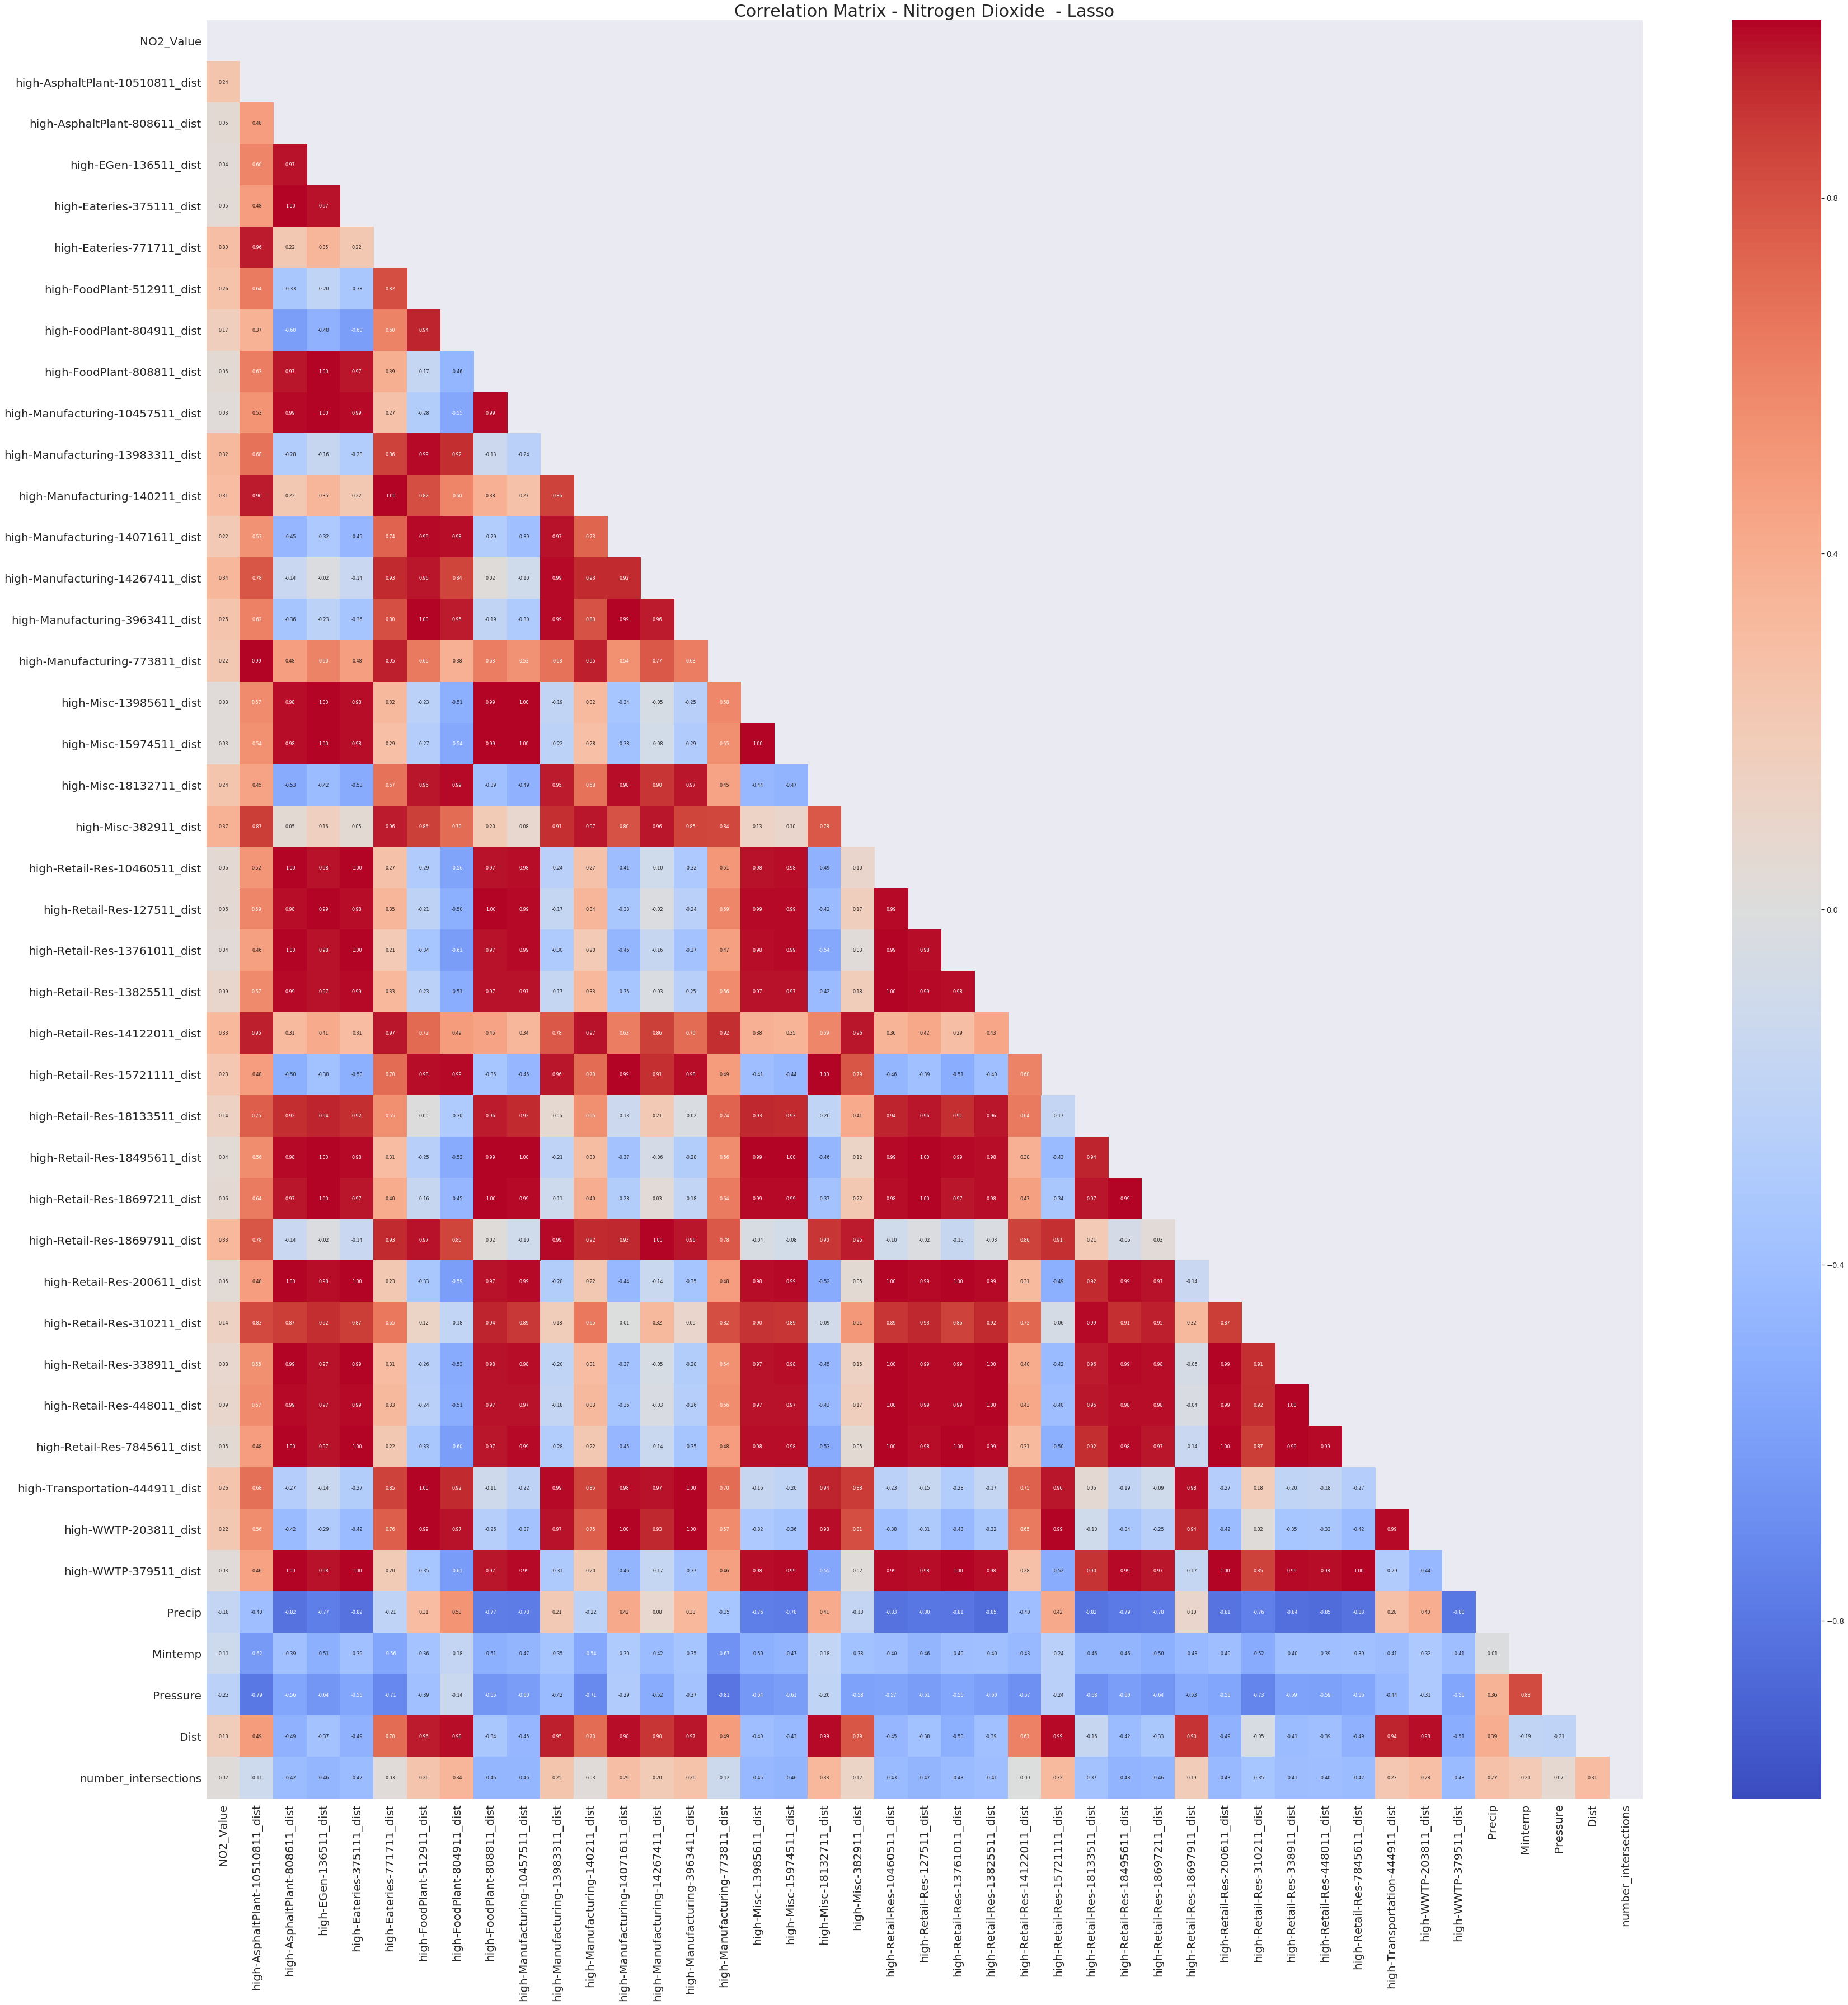

In [300]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr_NO2[np.triu_indices_from(arr_corr_NO2)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr_NO2, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(Lasso_NO2_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(Lasso_NO2_corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(Lasso_NO2_corr.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Nitrogen Dioxide  - Lasso', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

<b> <font size = 5> Step Forward Approach with VIF Scores calculations </b> </font>

The approach here is to keep adding features sequentially, and calculate the VIF score with addition of each feature. If the VIF score of any of the features increases above threshold of 10, then we drop the newly added feature. 

<b> <font size = 3> BC Dataset </b> </font>

<b> First, create a dataframe with y and standardized x values. Then create a dataframe in VIF format i.e. each column header should be Q('column name'), except the target variable.   </b>

In [306]:
y_BC_vif = BC[['BC_Value']]
X_BC_vif = BC.drop(columns = ['BC_Value'])
X_BC_scaled_vif = pd.DataFrame(StandardScaler().fit_transform(X_BC_vif), index = X_BC_vif.index, columns = X_BC_vif.columns)
BC_scaled_df = pd.concat([y_BC_vif,X_BC_scaled_vif], axis=1)

In [307]:
#Update column name for X_BC and Y_BC to be of format Q('Column Name')
output_featurelist_BC = []

for feature_name in X_BC_scaled_vif.columns:
    output_featurelist_BC.append("Q('" + feature_name + "')")
output_features_BC = ' + '.join(output_featurelist_BC)

In [308]:
#  get y and X dataframes based on this regression:
y_BC_vif, X_BC_vif = dmatrices('BC_Value ~' + output_features_BC, BC_scaled_df, return_type='dataframe')


In [311]:
#output_featurelist = []
vif_score = []
vif_BC = pd.DataFrame()


## In this function, you pass the features, feature_df in the format Q(' ') and the entire dataframe with scaled values
def calculate_vif_BC(feature_df,df):
    thresh = 10
    output = pd.DataFrame()
    output_featurelist = []
    k = feature_df.shape[1]
    for i in range(1,k):
        output_featurelist.append(feature_df.columns[i]) # Start with the first column, and append the next column with every iteration
        #random.shuffle(output_featurelist)
        output_features = ' + '.join(output_featurelist)
        y_BC, X_BC = dmatrices('BC_Value ~' + output_features, df, return_type='dataframe') #Create matrix each time a column is appended
        

        # For each X, calculate VIF and save in dataframe
        vif = [variance_inflation_factor(X_BC.values, j) for j in range(X_BC.shape[1])] #Calculate VIF score for each model
        shouldDropFeature = False
        for j in range(len(vif)):
            if vif[j] > thresh:
                shouldDropFeature = True
        
        if shouldDropFeature:
            # Drop latest feature if VIF is > 10 for any feature after adding latest feature
            output_featurelist = output_featurelist[:-1]
            
    # Create final feature list    
    final_output_featurelist = output_featurelist
    final_output_features = ' + '.join(final_output_featurelist)

    
    #Recalculate X and Y for final feature list
    y_BC, X_BC = dmatrices('BC_Value ~' + final_output_features, df, return_type='dataframe')
    
    #Estimate VIF score for final feature list
    vif_BC["VIF Factor"] = [variance_inflation_factor(X_BC.values, i) for i in range(X_BC.shape[1])]
    vif_BC["features"] = X_BC.columns

    #Fit an OLS model for the final features that are selected and return summary statistics, VIF scores
    BC_ols_model = sm.OLS(y_BC, X_BC)
    BC_ols_results = BC_ols_model.fit()
    return vif_BC, BC_ols_results.summary()

        

In [312]:
calculate_vif_BC(X_BC_vif, BC_scaled_df)

(   VIF Factor                              features
 0    1.000000                             Intercept
 1    2.709092  Q('high-AsphaltPlant-10510811_dist')
 2    9.986754    Q('high-AsphaltPlant-808611_dist')
 3    8.110277                           Q('Precip')
 4    8.079292                        Q('Radiation')
 5    8.090749                          Q('Mintemp'),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               BC_Value   R-squared:                       0.172
 Model:                            OLS   Adj. R-squared:                  0.172
 Method:                 Least Squares   F-statistic:                     895.2
 Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
 Time:                        22:23:56   Log-Likelihood:                -17676.
 No. Observations:               21488   AIC:                         3.536e+04
 Df Residuals:    

In [324]:
#Create a dataframe with the features that were selected from VIF for BC
VIF_BC_df = BC[['BC_Value']].join(BC[['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist', 'Precip','Radiation','Mintemp']])

In [328]:
VIF_BC_corr = VIF_BC_df.corr()
VIF_BC_corr_arr = VIF_BC_corr.as_matrix()

module://ipykernel.pylab.backend_inline


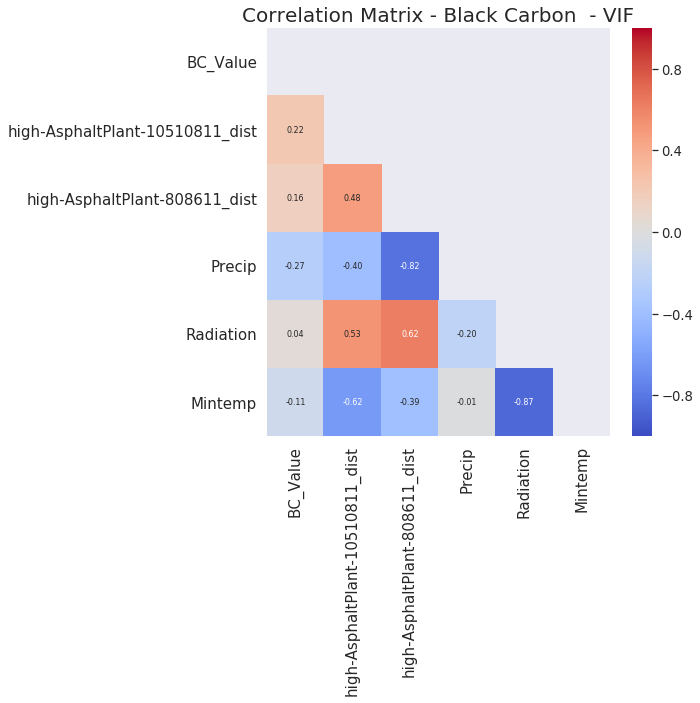

In [335]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
VIF_BC_corr_arr[np.triu_indices_from(VIF_BC_corr_arr)] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

hm = sns.heatmap(VIF_BC_corr_arr, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(VIF_BC_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(VIF_BC_corr.columns, rotation=90, fontsize=15)
ax.set_yticks(ticks)
ax.set_yticklabels(VIF_BC_corr.index, rotation=360, fontsize=15)

ax.set_title('Correlation Matrix - Black Carbon  - VIF', fontsize  = 20)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

<b> <font size = 3> NO2 Dataset </b> </font>

<b> First, create a dataframe with y and standardized x values. Then create a dataframe in VIF format i.e. each column header should be Q('column name'), except the target variable.   </b>

In [336]:
y_NO2_vif = NO2[['NO2_Value']]
X_NO2_vif = NO2.drop(columns = ['NO2_Value'])
X_NO2_scaled_vif = pd.DataFrame(StandardScaler().fit_transform(X_NO2_vif), index = X_NO2_vif.index, columns = X_NO2_vif.columns)
NO2_scaled_df = pd.concat([y_NO2_vif,X_NO2_scaled_vif], axis=1)

In [337]:
#Update column name for X_BC and Y_BC to be of format Q('Column Name')
output_featurelist_NO2 = []

for feature_name in X_NO2_scaled_vif.columns:
    output_featurelist_NO2.append("Q('" + feature_name + "')")
output_features_NO2 = ' + '.join(output_featurelist_NO2)

In [338]:
#  get y and X dataframes based on this regression:
y_NO2_vif, X_NO2_vif = dmatrices('NO2_Value ~' + output_features_NO2, NO2_scaled_df, return_type='dataframe')


In [339]:
#output_featurelist = []
vif_score = []
vif_NO2 = pd.DataFrame()

def calculate_vif_NO2(feature_df,df):
    thresh = 10
    output = pd.DataFrame()
    output_featurelist = []
    k = feature_df.shape[1]
    for i in range(1,k):
        output_featurelist.append(feature_df.columns[i])
        #random.shuffle(output_featurelist)
        output_features = ' + '.join(output_featurelist)
        y_NO2, X_NO2 = dmatrices('NO2_Value ~' + output_features, df, return_type='dataframe')
        

        # For each X, calculate VIF and save in dataframe
        vif = [variance_inflation_factor(X_NO2.values, j) for j in range(X_NO2.shape[1])]
        shouldDropFeature = False
        for j in range(len(vif)):
            if vif[j] > thresh:
                shouldDropFeature = True
        
        if shouldDropFeature:
            # Drop latest feature if VIF is > 10 for any feature after adding latest feature
            output_featurelist = output_featurelist[:-1]
            
    # Create final feature list    
    final_output_featurelist = output_featurelist
    final_output_features = ' + '.join(final_output_featurelist)
    
    #Recalculate X and Y for final feature list
    y_NO2, X_NO2 = dmatrices('NO2_Value ~' + final_output_features, df, return_type='dataframe')
    
    #Estimate VIF score for final feature list
    vif_NO2["VIF Factor"] = [variance_inflation_factor(X_NO2.values, i) for i in range(X_NO2.shape[1])]
    vif_NO2["features"] = X_NO2.columns
    
    NO2_ols_model = sm.OLS(y_NO2, X_NO2)
    NO2_ols_results = NO2_ols_model.fit()
    return vif_NO2, NO2_ols_results.summary()

        

In [340]:
calculate_vif_NO2(X_NO2_vif, NO2_scaled_df)

(   VIF Factor                              features
 0    1.000000                             Intercept
 1    2.709092  Q('high-AsphaltPlant-10510811_dist')
 2    9.986754    Q('high-AsphaltPlant-808611_dist')
 3    8.110277                           Q('Precip')
 4    8.079292                        Q('Radiation')
 5    8.090749                          Q('Mintemp'),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              NO2_Value   R-squared:                       0.201
 Model:                            OLS   Adj. R-squared:                  0.201
 Method:                 Least Squares   F-statistic:                     1081.
 Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
 Time:                        22:33:24   Log-Likelihood:                -76898.
 No. Observations:               21488   AIC:                         1.538e+05
 Df Residuals:    

The model based on the step forward VIF approach is not resulting in a great fit. The R2 score for the OLS models is worse than what we saw with the lasso gridsearch method.

In [341]:
#Create a dataframe with the features that were selected from VIF for BC
VIF_NO2_df = NO2[['NO2_Value']].join(NO2[['high-AsphaltPlant-10510811_dist', 'high-AsphaltPlant-808611_dist', 'Precip','Radiation','Mintemp']])

In [342]:
VIF_NO2_corr = VIF_NO2_df.corr()
VIF_NO2_corr_arr = VIF_NO2_corr.as_matrix()

module://ipykernel.pylab.backend_inline


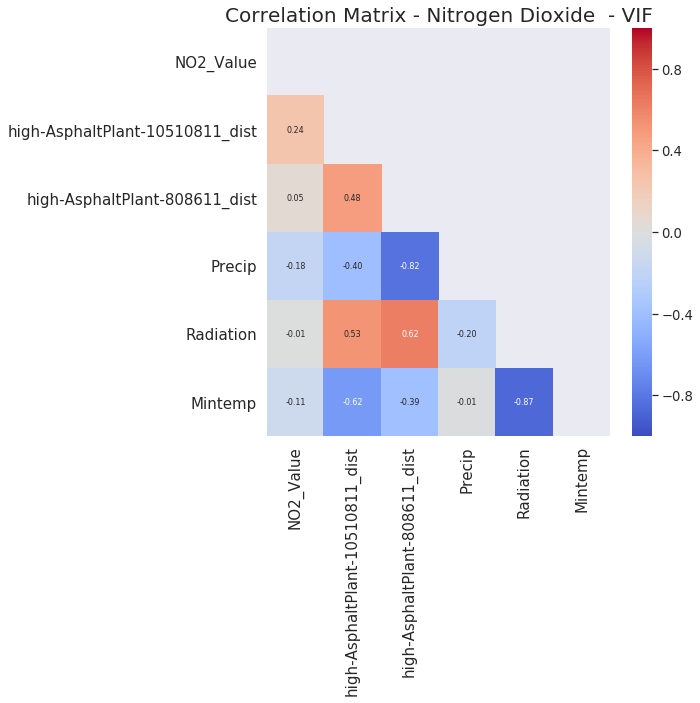

In [343]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
VIF_NO2_corr_arr[np.triu_indices_from(VIF_NO2_corr_arr)] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

hm = sns.heatmap(VIF_NO2_corr_arr, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(VIF_NO2_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(VIF_NO2_corr.columns, rotation=90, fontsize=15)
ax.set_yticks(ticks)
ax.set_yticklabels(VIF_NO2_corr.index, rotation=360, fontsize=15)

ax.set_title('Correlation Matrix - Nitrogen Dioxide  - VIF', fontsize  = 20)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

<b> <font size = 5> Principal Component Analysis for Feature Selection</b> </font>

<b> <font size = 4> BC Dataset</b> </font>

In [372]:
y_BC_original = BC[['BC_Value']]
X_BC_original = BC.drop(columns = 'BC_Value')

In [373]:
# Create the test train split again from the original data, without scaling
X_train_BC_PCA, X_test_BC_PCA, y_train_BC_PCA, y_test_BC_PCA = train_test_split(X_BC_original, y_BC_original, test_size=0.30, random_state=0)

Here, the idea is to setup a pipeline to first standardize the data using standard scaler, then fit a PCA model and then use a decision tree regressor on the training dataset. Next, do a gridsearch over differen tree depths, fit the training data to the model and use cross-validation to evaluate the model. Finally, we make predictions based on the fitted model on the test set and the entire dataset and calculate a cross-validation score. 

In [ ]:
#Create a Scaler object
sc = StandardScaler()

#Instantiate PCA
pca = PCA()

#Create decision tree regressor object
dtreeReg = DecisionTreeRegressor()

# Create a pipeline of three steps. First, standardize the data.
# Second, transform the training data with PCA.
# Third, train a Decision Tree Regressor on the training data.
pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('dtreeReg', dtreeReg)])


# Create Parameter Space
# Create a list of a sequence of integers from 1 to 68 (the number of features in X + 1)
n_components = list(range(1,X_train_BC_PCA.shape[1]+1,1))


# Create lists of parameter for DecisionTreeRegressor. Here we use mse as the criterion
criterion = ['mse']
max_depth = [4,6,8,10]


# Create a dictionary of all the parameter options 

parameters = dict(pca__n_components=n_components,
                dtreeReg__criterion=criterion,
                dtreeReg__max_depth=max_depth)


# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)


# Fit the grid search on training data
clf.fit(X_train_BC_PCA, y_train_BC_PCA)

# View The Best Parameters
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['dtreeReg'])


# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_test_BC_PCA, y_test_BC_PCA, cv=5, n_jobs=-1, scoring='r2')
print("CV Result for each set: ", CV_Result)
print("Mean CV result for PCA and Decision Tree Model: ", CV_Result.mean())


## Make predictions based on fitted model
y_pred_BC_PCA_test = clf.predict(X_test_BC_PCA)
y_pred_BC_PCA = clf.predict(X_BC_original)


### Print the components and explained variance
#clf.best_estimator_.named_steps['pca'].components_
print(clf.best_estimator_.named_steps['pca'].explained_variance_ratio_)

In [ ]:
#Calculate the R2 on the predicted y and original y value
print("R2 on the predicted y and original BC value is:", r2_score(y_BC_original, y_pred_BC_PCA))
print("R2 on the predictted y on the test dataset and BC value of test dataset is:", r2_score(y_test_BC_PCA, y_pred_BC_PCA_test))

In [ ]:
# Creating a plot of BC concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = y_BC_original, y = y_pred_BC_PCA, fit_reg=True)
ax.set(xlabel = 'Actual BC Concentrations (ug/m3)', ylabel = 'Predicted BC Concetrations (ug/m3)')
plt.title('Actual vs. Predicted BC Concentration')
plt.text(6 , 7 ,"R2 = 0.779", fontsize = 18)


In [ ]:
#Explained variance ratio
explained_var = np.cumsum(clf.best_estimator_.named_steps['pca'].explained_variance_ratio_)
print(explained_var)

The PCA + DecisionTree Regressor resulted in the selection of 31 components, and the mean cross validation score for the test dataset is 0.60. Predicting the 'y' value based on the model results in an R2 value of 0.78. 99% of the variance in the model is explained with these 31 selected components. 

<b> <font size = 4> NO2 Dataset</b> </font>

In [374]:
y_NO2_original = NO2[['NO2_Value']]
X_NO2_original = NO2.drop(columns = 'NO2_Value')

In [375]:
# Create the test train split again from the original data, without scaling
X_train_NO2_PCA, X_test_NO2_PCA, y_train_NO2_PCA, y_test_NO2_PCA = train_test_split(X_NO2_original, y_NO2_original, test_size=0.30, random_state=0)

In [ ]:
#Create a Scaler object
sc = StandardScaler()

#Instantiate PCA
pca = PCA()

#Create decision tree regressor object
dtreeReg = DecisionTreeRegressor()

# Create a pipeline of three steps. First, standardize the data.
# Second, transform the training data with PCA.
# Third, train a Decision Tree Regressor on the training data.
pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('dtreeReg', dtreeReg)])


# Create Parameter Space
# Create a list of a sequence of integers from 1 to 68 (the number of features in X + 1)
n_components = list(range(1,X_train_NO2_PCA.shape[1]+1,1))


# Create lists of parameter for DecisionTreeRegressor. Here we use mse as the criterion
criterion = ['mse']
max_depth = [4,6,8,10]


# Create a dictionary of all the parameter options 

parameters = dict(pca__n_components=n_components,
                dtreeReg__criterion=criterion,
                dtreeReg__max_depth=max_depth)


# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf_NO2 = GridSearchCV(pipe, parameters)


# Fit the grid search on training data
clf_NO2.fit(X_train_NO2_PCA, y_train_NO2_PCA)

# View The Best Parameters
print('Best Number Of Components:', clf_NO2.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_NO2.best_estimator_.get_params()['dtreeReg'])


# Use Cross Validation To Evaluate Model
CV_Result_NO2 = cross_val_score(clf_NO2, X_test_NO2_PCA, y_test_NO2_PCA, cv=5, n_jobs=-1, scoring='r2')
print("CV Result for each set: ", CV_Result_NO2)
print("Mean CV result for PCA and Decision Tree Model: ", CV_Result_NO2.mean())


## Make predictions based on fitted model
y_pred_NO2_PCA_test = clf_NO2.predict(X_test_NO2_PCA)
y_pred_NO2_PCA = clf_NO2.predict(X_NO2_original)


### Print the components and explained variance
#clf.best_estimator_.named_steps['pca'].components_
print(clf_NO2.best_estimator_.named_steps['pca'].explained_variance_ratio_)

In [ ]:
#Calculate the R2 on the predicted y and original y value
print("R2 on the predicted y and original NO2 value is:", r2_score(y_NO2_original, y_pred_NO2_PCA))
print("R2 on the predictted y on the test dataset and NO2 value of test dataset is:", r2_score(y_test_NO2_PCA, y_pred_NO2_PCA_test))

In [ ]:
# Creating a plot of NO2 concentration vs predicted concentration using OLS
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plt.figure(figsize = (8,6))
ax = sns.regplot(x = y_NO2_original, y = y_pred_NO2_PCA, fit_reg=True)
ax.set(xlabel = 'Actual NO2 Concentrations (ppb)', ylabel = 'Predicted NO2 Concetrations (ppb)')
plt.title('Actual vs. Predicted NO2 Concentration')
plt.text(45 , 55 ,"R2 = 0.88", fontsize = 18)


The PCA + DecisionTree Regressor resulted in the selection of 50 components, and the mean cross validation score for the test dataset is 0.78. Predicting the 'y' value based on the model results in an R2 value of 0.88. 99% of the variance in the model is explained with these 50 selected components. 

<b> <font size = 5> Apply PCA And Test Performance of Several Models </b> </font>

In [385]:
def diff_model_test(x_test,y_test):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, x_test, y_test, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    results["RidgeCV"] = test_model(clf)

    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
 #   clf = linear_model.Lasso(alpha=1e-4)
 #   results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor(n_estimators = 200)
    results["RandomForest"]=test_model(clf)

    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    #results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results



<b> <font size = 4> BC Dataset </b> </font>

In [386]:
## USing PCA to test different models
#Create a Scaler object
scaler_BC = StandardScaler()

# Fit on training set only.
scaler_BC.fit(X_train_BC_PCA)

# Apply transform to both the training set and the test set.
X_train_BC2_PCA = scaler_BC.transform(X_train_BC_PCA)
X_test_BC_PCA = scaler_BC.transform(X_test_BC_PCA)

In [387]:
#Instantiate PCA
pca_BC = PCA(0.99) #Set the variance to be 0.99

pca_BC.fit(X_train_BC_PCA)


X_train_BC_PCA_trans = pca_BC.transform(X_train_BC_PCA)
X_test_BC_PCA_trans = pca_BC.transform(X_test_BC_PCA)

R Square Score
Linear                0.588995
Ridge                 0.566539
RidgeCV               0.583010
Bayesian Ridge        0.581687
Hubber                0.367403
Bagging               0.777361
RandomForest          0.790461

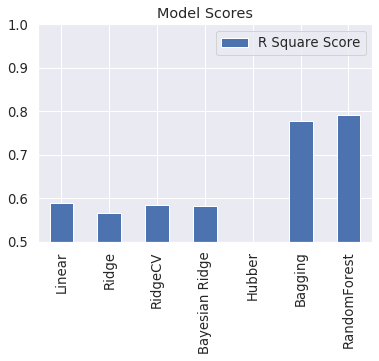

In [388]:
## Call the function on BC dataset
diff_model_test(X_train_BC_PCA, y_train_BC_PCA)


 <b> <font size = 4> NO2 Dataset </b> </font>

In [389]:
## USing PCA to test different models
#Create a Scaler object
scaler_NO2 = StandardScaler()

# Fit on training set only.
scaler_NO2.fit(X_train_NO2_PCA)

# Apply transform to both the training set and the test set.
X_train_NO2_PCA = scaler_NO2.transform(X_train_NO2_PCA)
X_test_NO2_PCA = scaler_NO2.transform(X_test_NO2_PCA)

In [390]:
#Instantiate PCA
pca = PCA(0.95)

pca.fit(X_train_NO2_PCA)


X_train_NO2_PCA_trans = pca.transform(X_train_NO2_PCA)
X_test_NO2_PCA_trans = pca.transform(X_test_NO2_PCA)

R Square Score
Linear                0.649465
Ridge                 0.616807
RidgeCV               0.636670
Bayesian Ridge        0.635459
Hubber                0.540464
Bagging               0.884372
RandomForest          0.892902

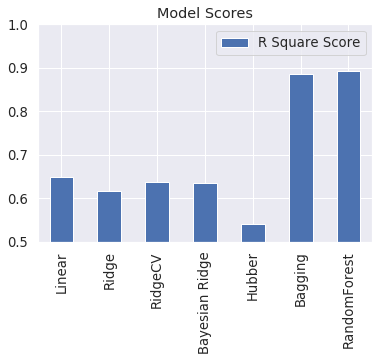

In [391]:
## Call the function on NO2 dataset
diff_model_test(X_train_NO2_PCA, y_train_NO2_PCA)


<b> Reference </b>: 

    Feature Selection with Pandas: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
    
    Linear Regression Models: https://towardsdatascience.com/linear-regression-models-4a3d14b8d368
    
    
    VIF: https://etav.github.io/python/vif_factor_python.html
    
    
    Wrapper methods: https://stackabuse.com/applying-wrapper-methods-in-python-for-feature-selection/
    
    
    Decision Tree Regressor: https://www.dezyre.com/recipes/create-and-optimize-baseline-decision-tree-model-for-regression
    
    PCA: Method mentioned here: https://www.dezyre.com/recipes/create-and-optimize-baseline-decision-tree-model-for-regression